In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### The whole graph

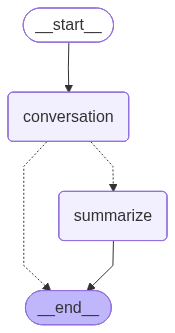

In [19]:
from IPython.display import display, Image
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, RemoveMessage
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_openai import ChatOpenAI
from typing import Literal
from langgraph.checkpoint.memory import MemorySaver
from pprint import pprint


llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

class State(MessagesState):
    summary : str

def conversation(state: State):

    summary = state.get("summary", "")
    if summary:
        summaryMsg =  f"The summary of the conversation so far is : {summary}"

        messages = SystemMessage(content=summaryMsg) + state["messages"]

    else:
        messages = state["messages"]

    response = llm.invoke(messages)
    return {"messages" : response}


def summarize(state: State):

    summary = state.get("summary","")
    if summary :

        summaryMsg =  f"The summary of the conversation so far is : {summary}. Generate new summary taking into account the new messages"

    else:
        summaryMsg =  f"Generate a summary of the conversation so far"

    messages = HumanMessage[SystemMessage(content=summaryMsg)] + state["messages"]
    response = llm.invoke(messages)

    delete_messages = [RemoveMessage(id = msg.id) for msg in state["messages"][:-2]]

    return {"messages" : delete_messages, "summary" : response.content}


def should_continue(state: State) -> Literal[END, "summarize"]:

    if len(state["messages"]) > 6:
        return "summarize"
    
    return END


graph = StateGraph(State)

graph.add_node("conversation", conversation)
graph.add_node("summarize", summarize)

graph.add_edge(START, "conversation")
graph.add_conditional_edges("conversation", should_continue)
graph.add_edge("summarize", END)

memory = MemorySaver()
build = graph.compile(checkpointer= memory)
display(Image(build.get_graph().draw_mermaid_png()))





### Streaming - UPDATES

In [20]:
#Define a thread

config = {"configurable": {"thread_id" : "1"}}

for chunk in build.stream({"messages" : HumanMessage(content="My name is Junaid")}, config=config, stream_mode="updates"):
    print(chunk)

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


{'conversation': {'messages': AIMessage(content='Nice to meet you, Junaid! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 12, 'total_tokens': 27, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-D1gY1oe1xJIpL67eeCz3vG66qGymG', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019bf227-cbf1-7551-b505-218871dca90b-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 12, 'output_tokens': 15, 'total_tokens': 27, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


- We can see node_name : conversation is a dict with different keys -> messages, token_usage etc

In [23]:
for chunk in build.stream({"messages" : [HumanMessage(content="My name is Junaid")]}, config=config, stream_mode="updates"):
    chunk["conversation"]["messages"].pretty_print()

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================

Nice to meet you, Junaid! How can I assist you today?


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


- Streaming - VALUES

In [26]:
config = {"configurable": {"thread_id" : "3"}}

for chunk in build.stream({"messages" : HumanMessage(content="My name is Junaid")}, config=config, stream_mode="values"):
    for msg in chunk["messages"]:
        msg.pretty_print()
    print("-----")

================================ Human Message =================================

My name is Junaid
-----


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================ Human Message =================================

My name is Junaid
================================== Ai Message ==================================

Nice to meet you, Junaid! How can I assist you today?
-----


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
